# D213 - Advanced Data Analytics - Performance Assessment Task 2
## Joshua T. Funderburk

#### Programming Environment

In [1]:
from platform import python_version
print(f"Python version: {python_version()}")

Python version: 3.12.8


# Part I: Research Question

## A1: Research Question

The research question for this analysis is: "Can Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) and NLP techniques effectively analyze sentiment patterns in IMDb movie reviews to provide insights about viewer reception?"

## A2: Objectives or Goals

The goals of this analysis are:
1. To predict viewer sentiment (positive or negative) about movies based on the language and word choices used in their IMDb reviews.
2. To determine if a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) can effectively learn the patterns in IMDb review text that indicate positive versus negative viewer opinions about film.

## A3: Prescribed Network

A Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) is a neural network that can be trained to produce useful text classification predictions on text sequences on the IMDb review data set. GeeksforGeeks notes that while traditional RNNs often struggle to retain information over extended sequences, LSTM is designed to effectively capture and learn long-term dependencies in sequential data, which is essential for understanding sentiment expressed across multiple sentences in a review. Additional advantages of LSTM for this analysis include its ability to handle reviews of different lengths, proven effectiveness in text classification tasks, and strong compatibility with word embeddings.

# Part II: Data Preparation

## B1: Data Exploration

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sys

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
# Read text file as csv & load Data in to Pandas DataFrame
df = pd.read_csv(r'sentiment labelled sentences\imdb_labelled.txt', sep='\t', quoting=3, header=None, names=['Review', 'Sentiment'])

# Print top 5 rows of the DataFrame
df.head()

,Review,Sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [4]:
# Print the shape of the DataFrame
df.shape

(1000, 2)

In [5]:
# Drop null values from the dataframe
df.dropna(inplace=True)
df.isnull().sum()

Review       0
Sentiment    0
dtype: int64

In [6]:
# Check for NaN in the dataframe
df.isna().sum()

Review       0
Sentiment    0
dtype: int64

#### Presence of unusual characters

Analysis of character frequencies revealed various special characters including standard punctuation (.,!?), numeric characters (0-9), and a few non-standard characters (é, å). The dataset primarily contains standard ASCII characters with very few unusual or non-English characters.

In [26]:
# Get a count per character across all reviews
# Initial list of words/characters in reviews
reviews = df['Review']
char_counts = Counter()

for comment in reviews:
    char_counts.update(comment)

# Print each character and its count
for char, count in char_counts.most_common():
    print(f"{repr(char)}: {count}")

' ': 15354
'e': 7550
't': 5754
'a': 5012
'i': 4780
'o': 4599
's': 4234
'n': 4083
'r': 3515
'h': 3171
'l': 2970
'd': 2192
'c': 1855
'm': 1702
'u': 1678
'f': 1404
'y': 1361
'g': 1318
'w': 1178
'.': 1047
'p': 1009
'b': 922
'v': 898
',': 649
'k': 479
'I': 446
'T': 380
"'": 334
'-': 170
'A': 152
'S': 120
'j': 118
'x': 110
'B': 105
'E': 94
'H': 89
'!': 85
'"': 84
'C': 69
'L': 64
'N': 63
'W': 63
'O': 61
'0': 61
'D': 59
'M': 58
')': 56
'R': 55
'1': 54
'G': 50
'(': 50
'F': 45
'P': 42
'J': 41
'z': 36
'q': 36
'V': 34
'Y': 31
':': 25
'9': 22
'U': 21
'/': 20
'?': 15
'2': 15
'K': 14
'8': 13
';': 12
'5': 12
'*': 11
'&': 9
'3': 8
'7': 8
'4': 7
'Q': 6
'\x96': 5
'é': 4
'Z': 4
'+': 3
'\x85': 2
'6': 2
'$': 1
'%': 1
'å': 1
'\x97': 1
'X': 1


#### Calculate vocabulary size

After tokenization, the total vocabulary size is 3,134 unique words. This represents the distinct words across all reviews in the dataset.

In [8]:
# Calculate vocabulary size
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary_size: ", vocab_size)

Vocabulary_size:  3134


#### Word embedding length

Based on applying a fourth root calculation to the vocabulary size of 3,134), the proposed word embedding length is 7.

In [9]:
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
print("Proposed word embedding length: ", max_sequence_embedding)

Proposed word embedding length:  7


#### Statistical justification for the chosen maximum sequence length

The maximum sequence length was set to 35 based on analysis of review lengths. A maximum length of 35 was chosen because it captures 95% of all reviews, providing a good balance between information preservation and computational efficiency. The histogram visualization shows that most reviews are concentrated in the shorter length ranges, making 35 tokens an appropriate cutoff point.

In [10]:
# Determine min, med, and max lengths of reviews
review_length = []
for char_len in reviews:
    review_length.append(len(char_len.split(" ")))

review_max = np.max(review_length)
review_min = np.min(review_length)
review_median = np.median(review_length)
review_90 = np.percentile(review_length, 90)
review_95 = np.percentile(review_length, 95)
print("Max length of sequences is: ", review_max)
print("Mid length of sequences is: ", review_median)
print("Min length of sequences is: ", review_min)
print("90th Percentile Length:", review_90)
print("95th Percentile Length:", review_95)

Max length of sequences is:  73
Mid length of sequences is:  14.0
Min length of sequences is:  3
90th Percentile Length: 29.0
95th Percentile Length: 35.0


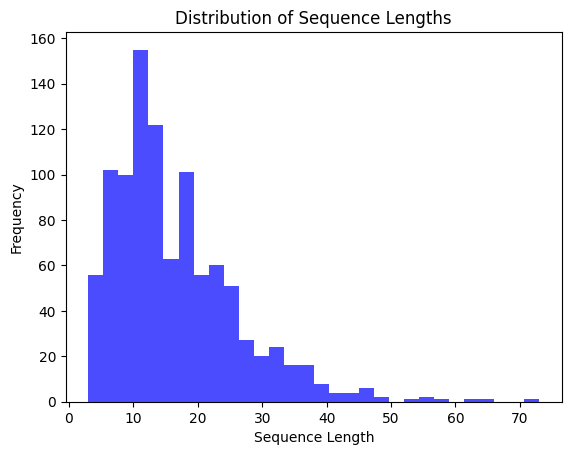

In [11]:
# Plot distribution of sequence lengths
plt.hist(review_length, bins=30, color='blue', alpha=0.7)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

#### Preprocessing

In [27]:
# Preprocessing
description_list = []
stop_words = stopwords.words('english')

for description in df.Review:
    # Remove punctuation and special characters
    description = re.sub("[^a-zA-Z]", " ", description)
    
    # Convert to lower case
    description = description.lower()
    
    # Tokenize
    description = nltk.word_tokenize(description)
    
    # Lemmatize
    lemma = nltk.WordNetLemmatizer()
    description = [lemma.lemmatize(word) for word in description]
    
    # Removes stopwords
    description = [word for word in description if not word in stop_words]
    description = " ".join(description)
    description_list.append(description)
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [13]:
# Splitting the data into training and test set.
X = np.array(description_list)
y = df.Sentiment.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 15, stratify = y)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

X_train = pd.Series(X_train)
X_test = pd.Series(X_test)

# View the training and testing sample sizes
print("Training size: ", X_train.shape)
print("Testing size: ", X_test.shape)

Training size:  (800,)
Testing size:  (200,)


## B2: Tokenization

The tokenization process breaks text into smaller, meaningful units called tokens (e.g., words or phrases). The primary goal of tokenization is to transform text into numerical sequences that can be understood by machine learning models while preserving the context of the data (Awan, 2024). To ensure effective tokenization, the data must also undergo normalization. This involves converting text to lowercase, removing special characters, and eliminating stopwords to reduce noise.

The code for tokenizing the training dataset is shown below. The process uses the tensorflow.keras.preprocessing.text.Tokenizer package to assign unique integer IDs to each word, enabling numerical representation of the text. Additionally, the pre-processing steps leverage the NLTK library for cleaning the text before tokenization.

In [28]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'movie': 2,
 'wa': 3,
 'film': 4,
 'one': 5,
 'bad': 6,
 'good': 7,
 'character': 8,
 'like': 9,
 'time': 10,
 'acting': 11,
 'really': 12,
 'ha': 13,
 'even': 14,
 'great': 15,
 'scene': 16,
 'well': 17,
 'see': 18,
 'ever': 19,
 'plot': 20,
 'way': 21,
 'story': 22,
 'made': 23,
 'make': 24,
 'love': 25,
 'would': 26,
 'actor': 27,
 'watching': 28,
 'look': 29,
 'script': 30,
 'work': 31,
 'think': 32,
 'seen': 33,
 'get': 34,
 'best': 35,
 'show': 36,
 'year': 37,
 'every': 38,
 'could': 39,
 'also': 40,
 'everything': 41,
 'wonderful': 42,
 'never': 43,
 'much': 44,
 'better': 45,
 'thing': 46,
 'cast': 47,
 'stupid': 48,
 'real': 49,
 'life': 50,
 'give': 51,
 'line': 52,
 'waste': 53,
 'performance': 54,
 'funny': 55,
 'know': 56,
 'art': 57,
 'go': 58,
 'totally': 59,
 'excellent': 60,
 'music': 61,
 'watch': 62,
 'still': 63,
 'two': 64,
 'many': 65,
 'little': 66,
 'minute': 67,
 'part': 68,
 'recommend': 69,
 'right': 70,
 'terrible': 71,
 'interesting': 72,
 'd

## B3: Padding Process

In this analysis, the maximum sequence length is set to 35, based on the value of review_95. The statistical analysis supporting this decision is detailed in Section B1.

The padding process uses post-padding for both the padding type and the truncation type. This choice is well-suited for the RNN-LSTM model used in this analysis, as these models process sequences sequentially, starting from the beginning. By using post-padding, the model processes the most meaningful tokens first, rather than encountering padding tokens at the start of the sequence. This approach helps preserve the initial context of each sequence, which is critical for sentiment analysis. The padding is implemented using the tensorflow.keras.preprocessing.sequence.pad_sequences function.

A single padded sequence is displayed below..

In [15]:
# Define padding parameters
max_length = int(review_95)
padding_type = 'post'
trunc_type = 'post'

# Apply padding to training data
sequences_train = tokenizer.texts_to_sequences(X_train)
padded_train = pad_sequences(sequences_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Apply padding to training data
sequences_test= tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Display a padded sequence
np.set_printoptions(threshold=sys.maxsize)
padded_train[0]

array([ 79, 131,  80,  37,   3, 859, 860,   4,  93,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

In [16]:
# Convert padded data to numpy array to be used in model
training_padded = np.array(padded_train)
training_label = np.array(y_train)
test_padded = np.array(padded_test)
test_label = np.array(y_test)

## B4: Categories of Sentiment

In this analysis, there are 2 categories of sentiment:
- Negative sentiment (0)
- Positive sentiment (1)

The distribution analysis shows the dataset is well-balanced:
- Positive reviews: 500
- Negative reviews: 500

The sigmoid activation function was chosen for the final dense layer of the network. The sigmoid function maps input values to an output range between 0 and 1, effectively representing probabilities. This characteristic makes it suitable for binary sentiment analysis, where the model outputs a probability indicating the likelihood of a particular sentiment (Rajan, 2021).

In [17]:
# Get counts of each sentiment category
sentiment_counts = df['Sentiment'].value_counts()
print("Number of sentiment categories:", len(sentiment_counts))
print("\nDistribution of sentiments:")
print(sentiment_counts)

Number of sentiment categories: 2

Distribution of sentiments:
Sentiment
0    500
1    500
Name: count, dtype: int64


<Axes: xlabel='Sentiment', ylabel='count'>

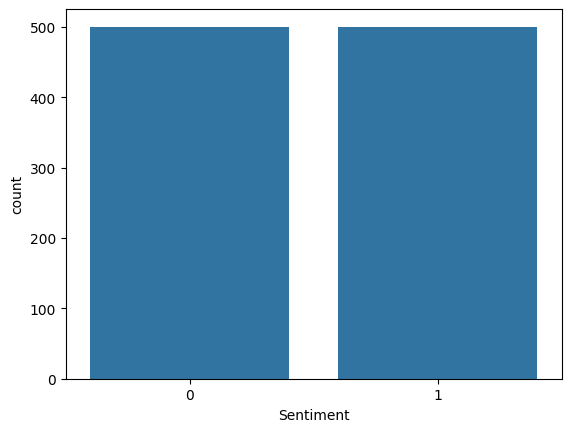

In [18]:
# Plotting distribution of sentiments in the dataset
sns.countplot(x='Sentiment', data=df)

## B5: Steps to Prepare the Data

The following are the steps completed to prepare the data:
1. Read the data from the dataset
    - Loaded imdb_labeled.txt as CSV using pandas
    - Created DataFrame with 'Review' and 'Sentiment' columns
2. Cleaned the data
    - Used dropna() to remove any null values from DataFrame
    - Verified with isna().sum() to confirm no missing values
3. Explored the data
    - Examined first 5 rows using df.head()
    - Checked DataFrame dimensions with df.shape
    - Analyzed character counts for unusual characters
    - Calculated vocabulary size
    - Determined optimal sequence length
4. Text normalization preprocessing using NLTK
    - Removed punctuation and special characters using regex
    - Converted all text to lowercase
    - Tokenized text into individual words
    - Applied lemmatization to standardize word forms
    - Removed English stopwords
5. Split data into training and test sets
    - Used 80/20 split ratio - per industry standard
6. Text vectorization with tokenizer
    - Created Tokenizer object
    - Fit tokenizer on training data to create word index
    - Converted text sequences to numeric form
    - Applied post-padding to standardize sequence length
7. Final array conversion
    - Converted padded sequences to numpy arrays
    - Transformed labels to numpy arrays
    - Transformed labels to numpy arrays
    - Created final training_padded and test_padded arrays

Note: A validation size of 20% will be used when training the model per industry standard.

## B6: Prepared Data Set

In [19]:
# Export the data to csv file
pd.DataFrame(training_padded).to_csv("training_padded.csv")
pd.DataFrame(training_label).to_csv("training_label.csv")
pd.DataFrame(test_padded).to_csv("test_padded.csv")
pd.DataFrame(test_label).to_csv("test_label.csv")

# Part III: Network Architecture

## C1: Model Summary

The following is the output of the model summary: 

In [20]:
# Define model parameters
activation = 'sigmoid' 
loss = 'binary_crossentropy' 
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

num_epochs = 20

# Define early stopping monitor
early_stopping_monitor = EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        restore_best_weights=True
    )

# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(int(review_95),)),
    tf.keras.layers.Embedding(vocab_size, output_dim=7),
    tf.keras.layers.LSTM(50, kernel_regularizer=tf.keras.regularizers.l2(0.001), recurrent_dropout=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation=activation)    
])

# Compile the model
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Train the model
history = model.fit(
    training_padded,
    training_label,
    validation_split=0.2,
    epochs=num_epochs,
    batch_size=50,
    callbacks=[early_stopping_monitor],
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 35, 7)               │          21,938 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          11,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,789 (131.99 KB)

 Trainable params: 33,689 (131.60 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5163 - loss: 0.7052 - val_accuracy: 0.5250 - val_loss: 0.7035
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5239 - loss: 0.7016 - val_accuracy: 0.5250 - val_loss: 0.7021
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4991 - loss: 0.7016 - val_accuracy: 0.4750 - val_loss: 0.7008
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5041 - loss: 0.6985 - val_accuracy: 0.4750 - val_loss: 0.6995
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7132 - loss: 0.6051 - val_accuracy: 0.7250 - val_loss: 0.6199
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9303 - loss: 0.2265 - val_accuracy: 0.7688 - val_loss: 0.5546
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9175 - loss: 0.2562 - val_accuracy: 0.7437 - val_loss: 0.6007
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9575 - loss: 0.1662 - val_accuracy: 0.7563 - v

## C2: Network Architecture


**The neural network consists of 5  layers:**
1. Embedding Layer
    - First layer in the network
    - Converts input tokens into dense vectors with a fixed size
    - Takes sequences with a of length 35 and outputs 7-dimensional embeddings
    - Contains 21,938 parameters
2. LSTM Layer
    - Main processing layer for sequential learning
    - 50 output units with L2 regularization
    - Contains 11,600 parameters
    - Crucial for capturing long-term dependencies in text
3. Batch Normalization Layer
    - Normalizes layer outputs to maintain stability
    - Contains 200 parameters:
        - 100 trainable parameters
        - 100 non-trainable parameters
    - Helps reduce internal covariate shift during training
4. Dropout Layer
    - 20% dropout rate
    - No trainable parameters
    - Helps prevent overfitting by randomly deactivating neurons during training
5. Dense Layer
    - Final output layer for binary classification
    - Single output node with sigmoid activation
    - 51 trainable parameters

**Total Parameters in Network:**
- Total parameters: 33,789
- Trainable parameters: 33,689
- Non-trainable parameters: 100


## C3: Hyperparameters

**Activation Functions**
- LSTM Layer: Default tanh
    - Justification: The default activation function, tanh, outputs values between -1 and 1, which helps in maintaining the stability of the LSTM's cell state and effectively learning long-term dependencies in sequence data (Tanh Activation Function for Deep Learning: A Complete Guide, 2023).
- Dense Layer: Sigmoid activation
    - Justification: Sigmoid outputs probabilities between 0 and 1, making it ideal for binary classification tasks like sentiment analysis (Brownlee, 2021).

**Number of Nodes per Layer**
- Embedding dimension (7)
    - Justification: This is determined by taken the fourth root of vocabulary size, which is a standard way of determining the embedding dimension. This number was adjusted during trial and error to improve model performance, but ultimately 7 nodes gave the best results for the model (Introducing tensorflow feature columns, 2017).
- LSTM units (50)
    - Justification: The number of LSTM units was determined through trial and error, balancing model complexity and performance while monitoring for overfitting.
- Dense Layer (1 node) 
    - Justification: A single neuron in the output layer is standard for binary classification tasks, providing a clear decision boundary (Brownlee, 2021).

**Loss Function**
- Binary cross-entropy
    - Justification: Specifically designed for binary classification problems (Brownlee, 2021).
 
**Optimizer**
- Adam optimizer
    - Justification: The Adam optimizer is an adaptive learning rate optimization algorithm that combines the advantages of the AdaGrad and RMSProp methods (Brownlee, 2021). It's particularly well-suited for problems with noisy gradients, which is common in text data where word frequencies and patterns can vary significantly across reviews

**Stopping Criteria**
- Early stopping configuration:
    - Monitoring 'val_loss': Most  reliable indicator of the model's generalization performance (Keras Documentation: Earlystopping).
    - Patience of 3: Allows for temporary flat lines while preventing wasteful training (Keras Documentation: Earlystopping).
    - Restore best weights = True: Ensures optimal model performance (Keras Documentation: Earlystopping).
    - Max epochs of 20: Provides sufficient training time while preventing excessive computation.

**Evaluation Metric**
- Accuracy
    - Jusitification: Accuracy  measures the proportion of correct predictions, suitable for balanced binary classification tasks (Brownlee, 2021).

# Part IV: Model Evaluation

## D1: Stopping Criteria

The use of early stopping directly improved the model's generalization by stopping training at the point where further epochs would likely lead to overfitting. By monitoring validation loss, the model avoided learning noise in the training data, which can occur with extended training. The optimal stopping point (epoch 9) ensured that the model preserved its ability to perform well on validation data. The improvement in accuracy up to 96.3% and the reduction in loss to 0.1292 underscore the balance achieved between training performance and validation generalization. Additionally, early stopping provided insights into the complexity of the task and the adequacy of the neural network's architecture. The plateau in validation metrics suggests that the network effectively captured the patterns in the dataset without requiring additional training epochs or adjustments to the architecture.

Epoch 9 is visualized below, which is the optimal epoch:
<br>
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9577 - loss: 0.1705 - val_accuracy: 0.7937 - val_loss: 0.4803

## D2: Fitness

The neural network demonstrates good fitness with appropriate measures implemented to prevent overfitting.

To assess the model's fitness, training accuracy and validation accuracy metrics are used.
- Training Accuracy: The model achieved a training accuracy of 95.77% by epoch 9, showing strong categorization performance on the training data.
- Validation Accuracy: The validation accuracy of 79.37% at epoch 9 indicates decent generalization. However there is about a 16% gap between training and validation performance which raises a concern for potential overfitting.

The following are techniques used in this analysis to address overfitting:
- L2 regularization (kernel_regularizer=0.001) added to LSTM layer to penalize large weights
- LSTM recurrent dropout of 0.1 reduces overfitting in recurrent connections
- Batch normalization implemented to stabilize learning and improve generalization
- Dropout layer with 20% rate added after the LSTM layer to randomly deactivate neurons during training
- Early stopping monitor with patience=3 tracks validation loss to prevent overtraining

The measures seemed to be effective because the model stopped training at the optimal epoch (epoch 9) before overfitting became apparent. The model would more likely suffer from overfitting than underfitting considering the accuracy of the validation data.

## D3: Training Process

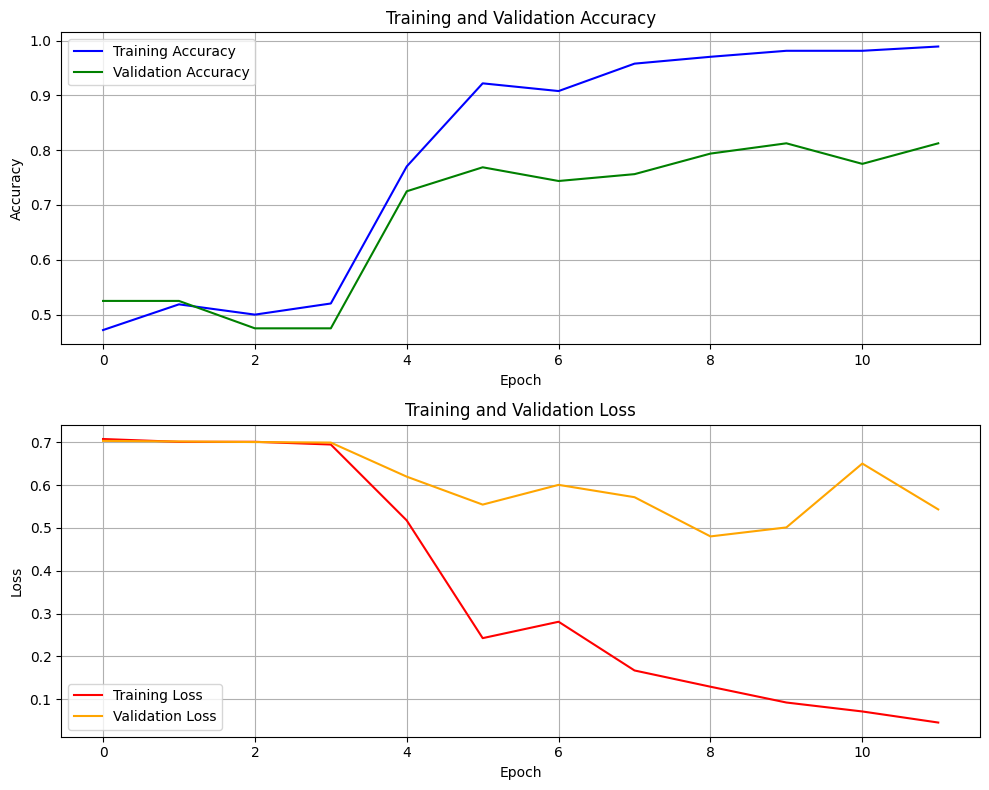

In [21]:
# Create visualization of the training process
plt.figure(figsize=(10, 8))

# Plot training & validation accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'g-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], 'r-', label='Training Loss')
plt.plot(history.history['val_loss'], 'orange', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

## D4: Predictive Accuracy

The test evaluation resulted in:
- Test accuracy: 0.7599 (76.0%)
- Test loss: 0.4689

The validation dataset resulted in:
- Validation accuracy: 0.7937 (79.4%)
- Validation loss: 0.4801

The model correctly classified about 76.0% of the IMDb reviews in the test set. This performance is quite good considering several factors:
1. Limited training data - the model was only trained on 640 reviews (with 160 for validation and 200 for testing)
2. Strong generalization - the model maintains consistent performance between validation (79.4%) and test accuracy (76.0%), with a difference of only 3.4 percentage points
3. Complex text data - movie reviews often contain:
    - Mixed sentiments within the same review
    - Sarcasm and nuanced language
    - Varied writing styles and lengths

Looking at a false negative example: "say film wa excellently produced top rating typical sci fi film" demonstrates some key challenges:
- The text appears truncated or poorly formatted ("wa" instead of "was")
- Contains positive phrases ("excellently produced", "top rating") but was misclassified
- The phrase "typical sci fi film" is ambiguous

In [22]:
# Perform predictions on the test data set
predictions = model.predict(test_padded)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [23]:
i = 12

print("Predicted review text:", X_test[i], "\n")
print("Predicted:", "Negative" if predictions[i][0] >= 0.5 else "Positive", "review")
print("Actual:", "Negative" if y_test[i] == 0 else "Positive", "review")

Predicted review text: say film wa excellently produced top rating typical sci fi film 

Predicted: Negative review
Actual: Positive review


In [24]:
score = model.evaluate(test_padded, test_label, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.5539973378181458 / Test accuracy: 0.7599999904632568


# Part V: Summary and Recommendations

## E: Code

In [25]:
# Save the model
model.save('IMDb_Sentiment_Analysis_Model.keras')

## F: Functionality

The neural network's functionality is built around sentiment analysis of IMDb reviews using NLP techniques. The model was trained on a dataset of 1,000 movie reviews, with 640 reviews used for training, 160 for validation, and 200 for testing. While this is a relatively small dataset, the model demonstrates effective learning capability.

The NLP processing pipeline follows several steps to analyze sentiments from the IMDb reviews:
1. Text preprocessing to clean and standardize reviews (removing punctuation, converting to lowercase)
2. Tokenization to convert text into numerical sequences using a vocabulary size of 3,134 unique words
3. Word embeddings to capture semantic relationships in a learned 7-dimensional space
4. Post-padding to standardize sequence lengths to 35 tokens maximum

The model was trained using labeled data where each review had a label of positive (1) or negative (0) representing the review's sentiment. This supervised learning approach enables the model to make predictions on unseen reviews by identifying learned sentiment patterns in the text.

The architectural impact of using an RNN-LSTM network is effective. Here is a breakdown of the architecture:
1. The embedding layer captures word relationships in a compact 7-dimensional space
2. The LSTM layer with 50 units successfully processes sequential text data
3. Regularization and batch normalization helped achieve consistent performance between validation (79.4%) and test (76.0%) sets
4. The final dense layer with sigmoid activation provides clear binary classification outputs

This architecture achieved a decent accuracy score of 76.0% on test data, demonstrating its ability to effectively analyze sentiment despite the small training dataset and complex IMDb review language.

This all being said, to answer the question of "Can Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) and NLP techniques effectively analyze sentiment patterns in IMDb movie reviews to provide insights about viewer reception?" - the results suggests yes. The RNN-LSTM model achieved good accuracy on test data while being trained on only 640 reviews, with good generalization between validation and test sets. Given these results on such a small dataset, it is reasonable to assume that a more robust training data set would yield even higher accuracy.

## G: Recommendations

Based on the results of this analysis, the most obvious recommendation is to expand the size of the dataset. Since the model achieved 76.0% accuracy with only 640 training examples, it is reasonable to assume that a more robust training dataset would yield even higher accuracy. Running another analysis on 10,000 IMDb reviews would be an excellent start in testing that assumption. Additionally, there are likely enhancements that could be made to text preprocessing. In the single example reviewing a false negative, there were obvious issues with either truncation or misspellings. To begin this process, a robust analysis of the incorrect classifications should be completed to try to narrow down more specific issues in either truncation, misspellings, sarcasm, etc. Finally, continued experimentation with the model, its layers, and its hyperparameters could help in yielding better accuracy results.

From a business perspective, continuing to work on the model would be the best next step. However, a model could be implemented on new reviews coming in to help determine sentiment and start making data-driven decisions based on that sentiment. At first, there would just be the caveat that it is only 76.0% accurate.

# Part VI: Reporting

## H: Reporting

Jupyter Notebook and the notebook in PDF form is included in this submission.

## I: Sources for Third-Party Code

Brownlee, J. (2021, January 21). How to choose an activation function for deep learning. MachineLearningMastery.com. https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning

Elleh, F. (2025, January). Advanced Data Analytics - Task 2. Task 2: Sentiment Analysis. Retrieved January 14, 2025, from https://westerngovernorsuniversity.sharepoint.com/:p:/r/sites/DataScienceTeam/Shared%20Documents/Graduate%20Team/D213/Student%20Facing%20Resources/D213%20Task%202%20Cohort%20Webinar%20PPT.pptx?d=w50f5b89a72f1496499421f3790ef1d59&csf=1&web=1&e=8YxRla. 

Elleh, F. (2025a, January). D213 Webinars. Lecture. 

Keras Documentation: Earlystopping. Keras. (n.d.). https://keras.io/api/callbacks/early_stopping

Rajan, S. (2021, August 26). Sentiment analysis using bidirectional stacked LSTM. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/08/sentiment-analysis-using-bidirectional-stacked-lstm

Sewell, W. (2025a, January). D213 Webinars. Lecture. 

## J: Sources

Awan, A. A. (2024, November 22). What is tokenization? types, use cases, implementation. DataCamp. https://www.datacamp.com/blog/what-is-tokenization 

Brownlee, J. (2021, January 21). How to choose an activation function for deep learning. MachineLearningMastery.com. https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning

GeeksforGeeks. (2024, June 10). What is LSTM - long short term memory?. GeeksforGeeks. https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/

Introducing tensorflow feature columns. Google Developers Blog. (2017, November 20). https://developers.googleblog.com/en/introducing-tensorflow-feature-columns 

Keras Documentation: Earlystopping. Keras. (n.d.). https://keras.io/api/callbacks/early_stopping 

Rajan, S. (2021, August 26). Sentiment analysis using bidirectional stacked LSTM. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/08/sentiment-analysis-using-bidirectional-stacked-lstm

Tanh Activation Function for Deep Learning: A Complete Guide. datagy. (2023, October 15). https://datagy.io/tanh-activation-function 